# RAG Fusion
    - rewriting queries, and then filtering and ranking things
    - this will bridge the gap between "what users explicitly ask AND what they intend to ask"

# Methodology
    step 1 : use seperate LLM to rewrite queries (generate similar queries)
    step 2 : perform vector search on all queries
    step 3 : rank the retrivials using "Reciprocal Rank Fusion" (RRF)
    step 4 : rerank the results 
    step 5 : generate the output

# Solid Example

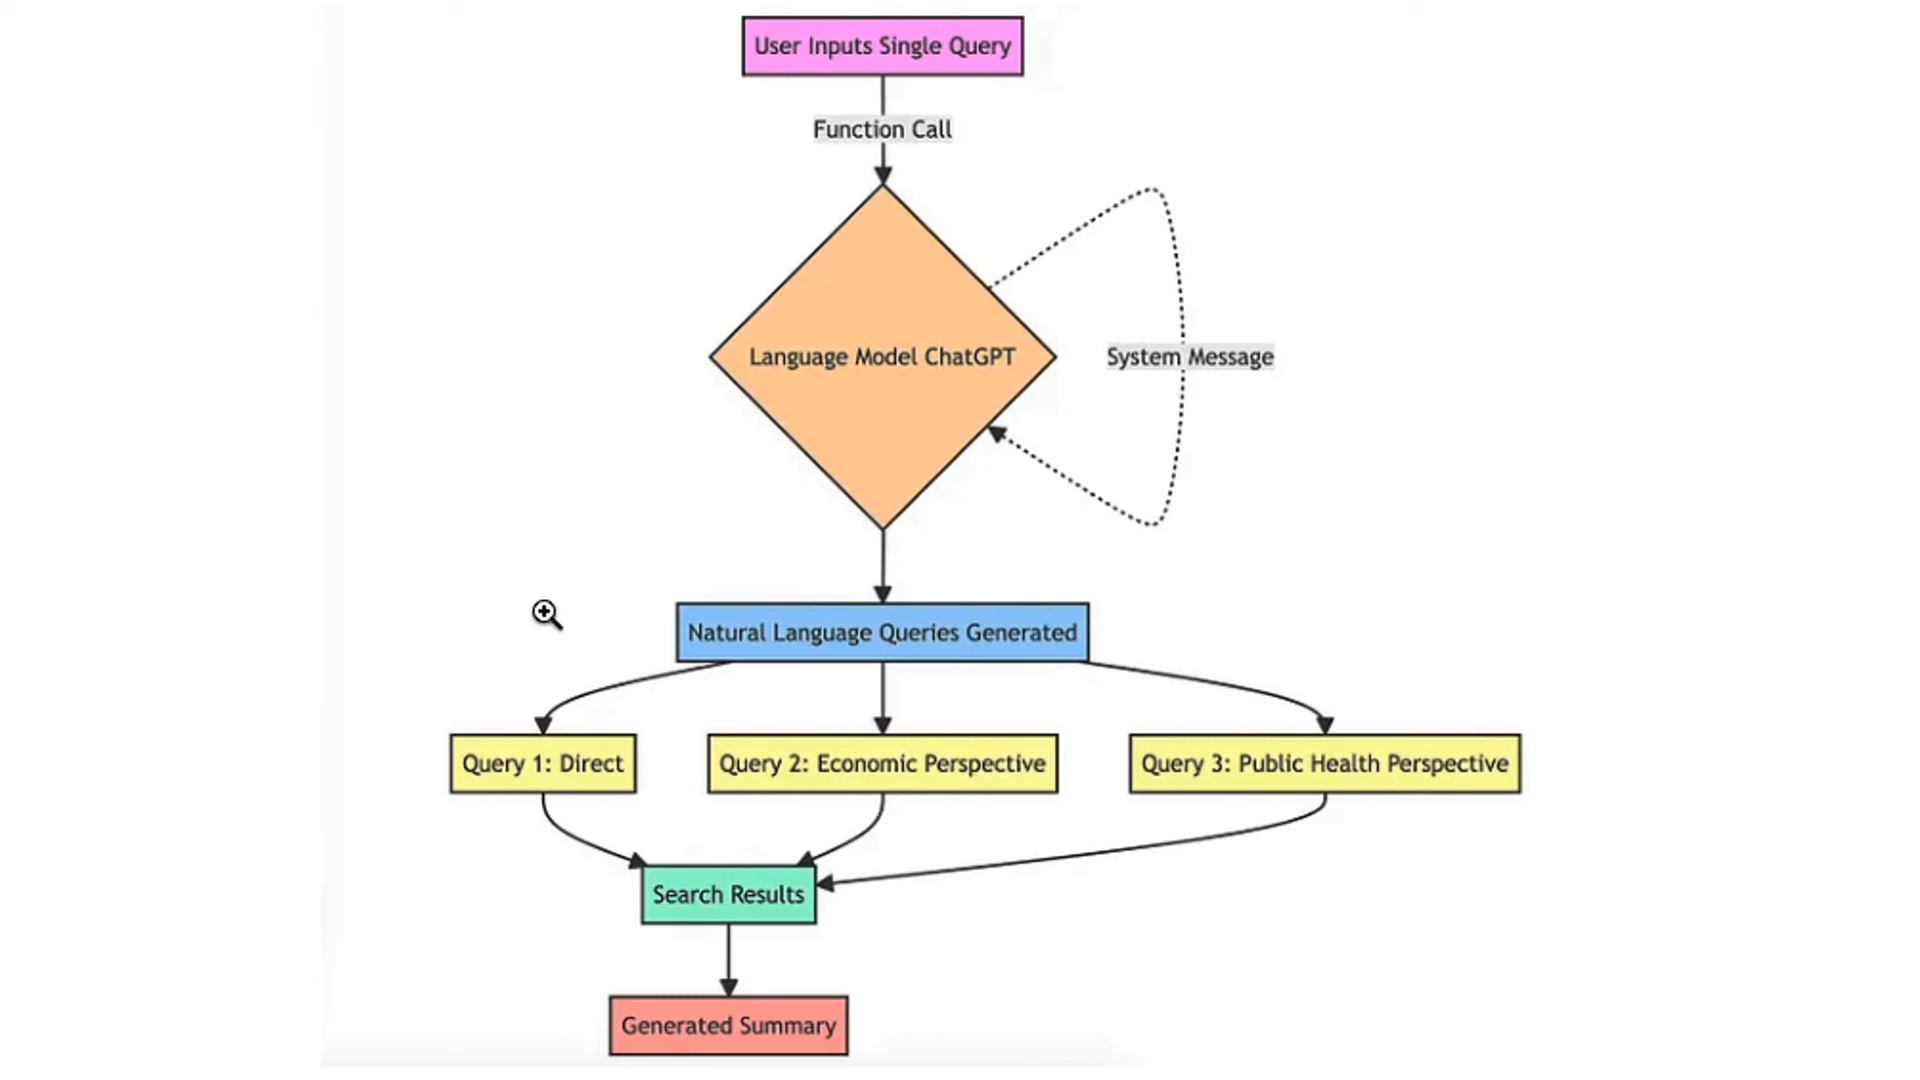

In [37]:
from langchain.load import dumps, loads
from langchain.vectorstores import Chroma
import yaml, os, openai, textwrap, langchain
from langchain.chains import LLMChain, RetrievalQA
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatMessagePromptTemplate, PromptTemplate

In [2]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ["OPENAI_API_TYPE"] = credentials['AD_OPENAI_API_TYPE']
os.environ["OPENAI_API_VERSION"] = credentials['AD_OPENAI_API_VERSION']
os.environ["OPENAI_API_BASE"] = credentials['AD_OPENAI_API_BASE']
os.environ["OPENAI_API_KEY"] = credentials['AD_OPENAI_API_KEY']

In [15]:
bge_embeddings = HuggingFaceBgeEmbeddings(
                                        model_name="BAAI/bge-small-en-v1.5",
                                        model_kwargs={'device': 'mps'},
                                        encode_kwargs={'normalize_embeddings': True}
                                        )

llm = AzureChatOpenAI(
                    deployment_name=credentials['AD_DEPLOYMENT_ID'],
                    model_name=credentials['AD_ENGINE'],
                    temperature=0.9, 
                    max_tokens = 256
                    )

In [6]:
loader = DirectoryLoader(
                        'data/singapore_text/', 
                        glob="*.txt", 
                        show_progress=True
                        )
docs = loader.load()

  0%|          | 0/646 [00:00<?, ?it/s][nltk_data] Downloading package punkt to /Users/1zuu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/1zuu/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
100%|██████████| 646/646 [00:18<00:00, 35.77it/s]


In [10]:
text_splitter = RecursiveCharacterTextSplitter(
                                                chunk_size = 500,
                                                chunk_overlap  = 100,
                                                length_function = len,
                                                is_separator_regex = False,
                                                )

docs = text_splitter.split_documents(docs)

In [11]:
len(docs)

6393

In [12]:
docs[1]

Document(page_content='The curatorial division of private arts institution LASALLE College of the Arts, this art space contains five galleries spread over 1500-square-metres of space. Students of the College also regularly exhibit in the galleries as part of their graduating shows, showcasing paintings, sculptures and installations to videos and photographs.', metadata={'source': 'data/singapore_text/Institute_of_Contemporary_Arts_Singapore.txt'})

In [20]:
if os.path.exists("./db/12"):
    db = Chroma(
                persist_directory="./db/12", 
                embedding_function=bge_embeddings
                )
else:
    db = Chroma.from_documents(
                                documents=docs,   
                                persist_directory="./db/12", 
                                embedding=bge_embeddings,
                                )

In [21]:
query = "Tell me about Universal Studios Singapore?"

db.similarity_search(query, k=5)

[Document(page_content='Universal Studios Singapore', metadata={'source': 'data/singapore_text/A_guide_to_kid-friendly_experiences_in_Sentosa.txt'}),
 Document(page_content='Universal Studios Singapore is a popular theme park that offers thrilling rides and entertainment for all ages. You can buy Universal Studios Singapore tickets and enjoy an unbeatable discount of 40% from MySingaporePass. The pass provides a hassle-free booking process, allowing you to skip the long queues and gain easy access to the park. Enjoy exhilarating roller coasters, live shows, and immersive themed zones inspired by your favorite movies. The discounted entry with My Singapore Pass', metadata={'source': 'data/singapore_text/My_Singapore_Pass__Unbeatable_Discounts_on_Singapore_Attractions_—_Hello!_Singapore_Tours.txt'}),
 Document(page_content='Link: https://www.visitsingapore.com/see\n\ndo\n\nsingapore/recreation\n\nleisure/fun\n\nthings\n\nto\n\ndo/universal\n\nstudios\n\nsingapore/\n\nTitle: Universal Stu

In [26]:
retriever = db.as_retriever(k=5)

# Basic Chat Chain

In [25]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [27]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [30]:
def wrap_text(text, width=90):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

In [31]:
text_reply = chain.invoke("Tell me about Universal Studio Singapore")

print(wrap_text(text_reply))

Universal Studios Singapore is a popular theme park in Southeast Asia that offers
thrilling rides and entertainment for all ages, inspired by favorite movies. Visitors can
buy tickets and enjoy an unbeatable discount of 40% from MySingaporePass. The pass
provides a hassle-free booking process, allowing visitors to skip the long queues and gain
easy access to the park. The park features exhilarating roller coasters, live shows, and
immersive themed zones. Some of the top attractions that can be booked with the My
Singapore Pass include Universal Studios Singapore at 40% off.


# With RAG Fusion

In [35]:
prompt = ChatPromptTemplate(
                            input_variables=['original_query'], 
                            messages=[
                                    SystemMessagePromptTemplate(
                                                            prompt=PromptTemplate(
                                                                                input_variables=[], 
                                                                                template='You are a helpful assistant that generates multiple search queries based on a single input query.'
                                                                                )
                                                                ), 
                                    HumanMessagePromptTemplate(
                                                            prompt=PromptTemplate(
                                                                                input_variables=['original_query'], 
                                                                                template='Generate multiple search queries related to: {question} \n OUTPUT (4 queries):'
                                                                                )
                                                                )
                                    ])

In [36]:
generate_queries = (
    prompt | llm | StrOutputParser() | (lambda x: x.split("\n"))
)

In [38]:
def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results

In [39]:
ragfusion_chain = generate_queries | retriever.map() | reciprocal_rank_fusion

In [40]:
langchain.debug = True

In [41]:
ragfusion_chain.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'question': {'title': 'Question', 'type': 'string'}}}

In [42]:
ragfusion_chain.invoke({"question": "universal studios Singapore"})

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "universal studios Singapore"
}
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "universal studios Singapore"
}
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
{
  "lc": 1,
  "type": "constructor",
  "id": [
    "langchain",
    "prompts",
    "chat",
    "ChatPromptValue"
  ],
  "kwargs": {
    "messages": [
      {
        "lc": 1,
        "type": "constructor",
        "id": [
          "langchain",
          "schema",
          "messages",
          "SystemMessage"
        ],
        "kwargs": {
          "content": "You are a helpful assistant that generates multiple search queries based on a single input query.",
          "additional_kwargs": {}
        }
      },
      {
        "lc": 1,
        "type": "constructor",
        "id": [
          "langchain",
          

[(Document(page_content='Universal Studios Singapore', metadata={'source': 'data/singapore_text/A_guide_to_kid-friendly_experiences_in_Sentosa.txt'}),
  0.05),
 (Document(page_content='Link: https://www.visitsingapore.com/see\n\ndo\n\nsingapore/recreation\n\nleisure/fun\n\nthings\n\nto\n\ndo/universal\n\nstudios\n\nsingapore/\n\nTitle: Universal Studios Singapore\n\nThe shimmering wonders of the silver screen comes to vivid life at Universal Studios Singapore, the first-ever Hollywood movie theme park in Southeast Asia.', metadata={'source': 'data/singapore_text/Universal_Studios_Singapore.txt'}),
  0.04839549075403121),
 (Document(page_content='The magic of Hollywood comes to life at Universal Studios Singapore (USS), a theme park filled with adrenaline-pumping rides, immersive live entertainment and a wide variety of attractions based on some of your favourite movie characters. Revisit childhood with your loved ones as you explore six distinct zones, from science-fiction worlds to th

In [43]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

full_rag_fusion_chain = (
                        {
                            "context": ragfusion_chain,
                            "question": RunnablePassthrough()
                        }
                        | prompt
                        | llm
                        | StrOutputParser()
                        )

In [44]:
full_rag_fusion_chain.input_schema.schema()

{'title': 'RunnableParallelInput',
 'type': 'object',
 'properties': {'question': {'title': 'Question', 'type': 'string'}}}

In [45]:
full_rag_fusion_chain.invoke({"question": "Tell me about Universal Studio Singapore?"})

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel] Entering Chain run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel > 3:chain:RunnablePassthrough] Entering Chain run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel > 3:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel > 4:chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel > 4:chain:RunnableSequence > 5:prompt:ChatPromptTemplate] Entering 

'Universal Studios Singapore is a popular theme park that offers thrilling rides and entertainment for all ages. The park features immersive themed zones inspired by your favorite movies and has 24 rides and attractions across seven themed zones, based on blockbuster movies and TV characters. You can buy Universal Studios Singapore tickets and enjoy an unbeatable discount of 40% from MySingaporePass. The pass provides a hassle-free booking process, allowing you to skip the long queues and gain easy access to the park.'